In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

def calculate_metrics(actual, predicted, model_name):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        return np.nan, np.nan, np.nan
    
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100
    mad = np.mean(np.abs(actual_clean - predicted_clean))
    rmse = np.sqrt(np.mean((actual_clean - predicted_clean) ** 2))
    
    print(f"\n{model_name}:")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  MAD: ${mad:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    
    return mape, mad, rmse

df = pd.read_csv(".././data/store_sales_over_time.csv", parse_dates=["date"])

## __Data Processing__

In [2]:
daily_sales = df.groupby("date")["sales"].sum().reset_index()
daily_sales = daily_sales.set_index("date")
monthly_sales = daily_sales.resample("ME").sum()

print(f"Date range: {df['date'].min()} a {df['date'].max()}")
print(f"Daily samples: {len(daily_sales)}")
print(f"Monthly samples: {len(monthly_sales)}")

Date range: 2013-01-01 00:00:00 a 2017-08-15 00:00:00
Daily samples: 1684
Monthly samples: 56


## __Data Analysis__

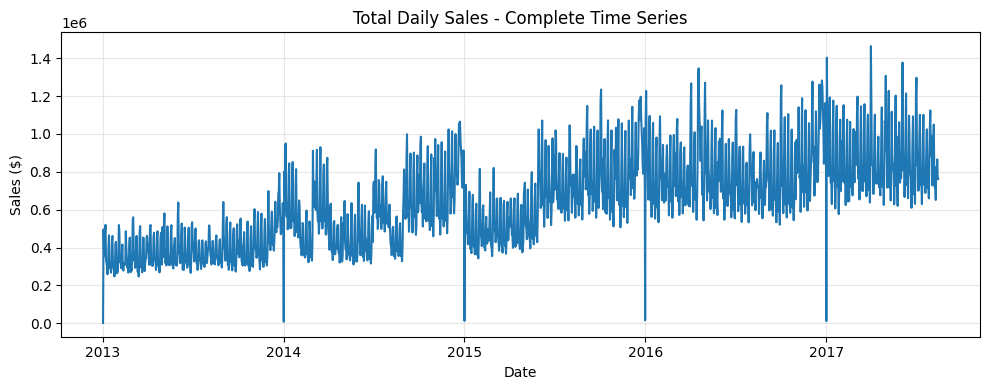

In [3]:
plt.figure(figsize=(10, 4))

plt.plot(daily_sales.index, daily_sales["sales"])
plt.title("Total Daily Sales - Complete Time Series")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/daily_sales.png")
plt.show()

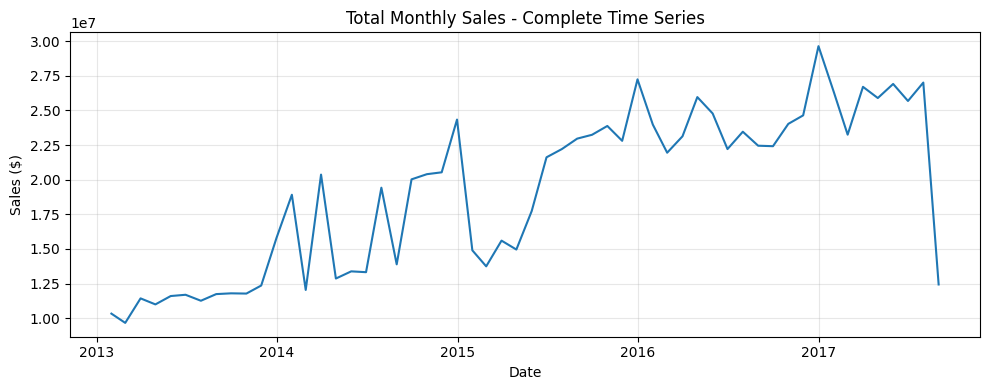

In [4]:
plt.figure(figsize=(10, 4))

plt.plot(monthly_sales.index, monthly_sales["sales"])
plt.title("Total Monthly Sales - Complete Time Series")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/monthly_sales.png")
plt.show()

## __Smoothing__

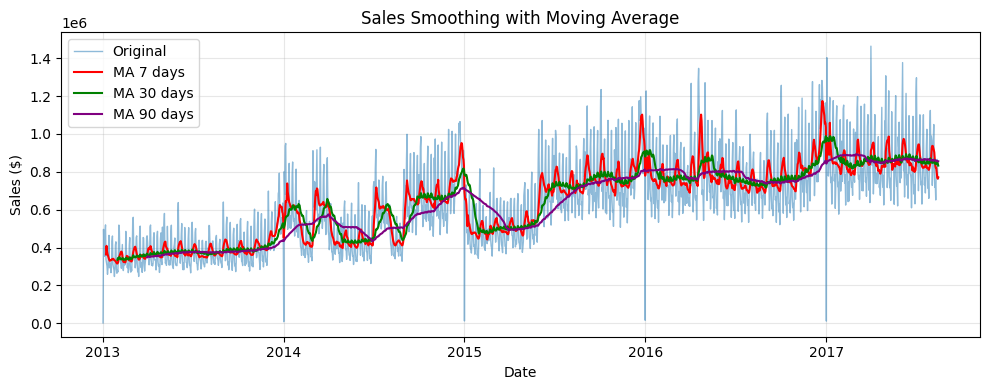

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(daily_sales.index, daily_sales["sales"], alpha=0.5, label="Original", linewidth=1)

# Diferentes ventanas de media móvil
windows = [7, 30, 90]  # 7 días, 30 días, 90 días
colors = ["red", "green", "purple"]

for window, color in zip(windows, colors):
    ma_sales = daily_sales["sales"].rolling(window=window).mean()
    plt.plot(daily_sales.index, ma_sales, label=f"MA {window} days", color=color)

plt.title("Sales Smoothing with Moving Average")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/moving_average.png")
plt.show()

## __Trend Analysis__

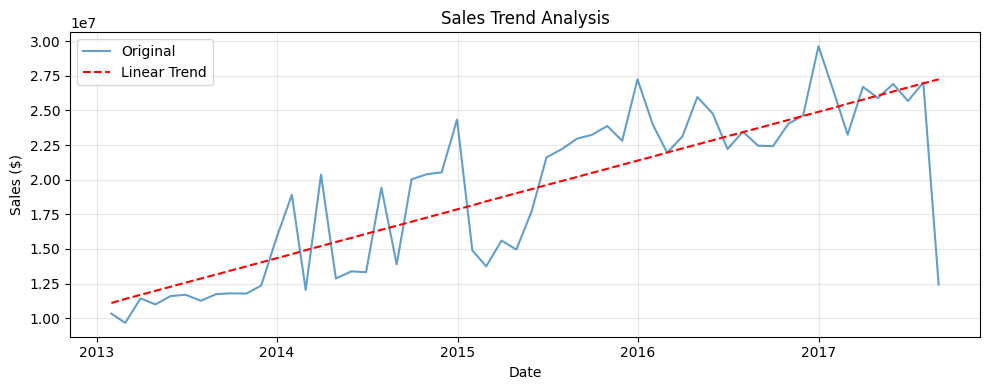

Trend: 293,677.37 (sales/month)


In [6]:
x = np.arange(len(monthly_sales))
y = monthly_sales["sales"].values

# Linear regression for the trend
coefficients = np.polyfit(x, y, 1)
trend_line = coefficients[0] * x + coefficients[1]

plt.figure(figsize=(10, 4))
plt.plot(monthly_sales.index, monthly_sales["sales"], alpha=0.7, label="Original")
plt.plot(monthly_sales.index, trend_line, "r--", label="Linear Trend")
plt.title("Sales Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/trend_analysis.png")
plt.show()

print(f"Trend: {coefficients[0]:,.2f} (sales/month)")

## __Decomposition__

<Figure size 1500x1200 with 0 Axes>

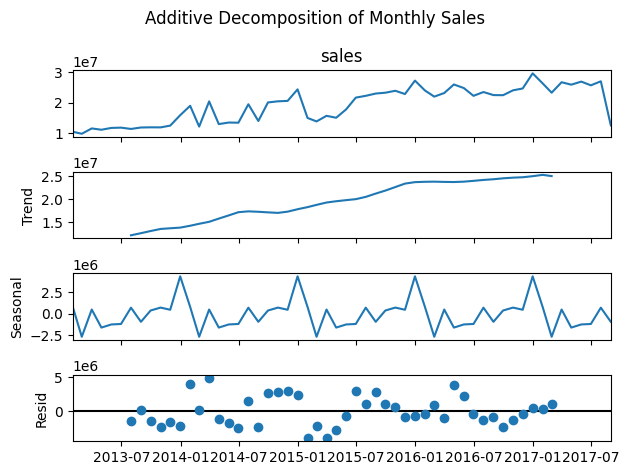

In [7]:
plt.figure(figsize=(15, 12))

result_add = seasonal_decompose(monthly_sales["sales"], model="additive", period=12)
result_add.plot()
plt.suptitle("Additive Decomposition of Monthly Sales")

plt.tight_layout()
plt.savefig("./figures/additive_decomposition.png")
plt.show()

<Figure size 1500x1200 with 0 Axes>

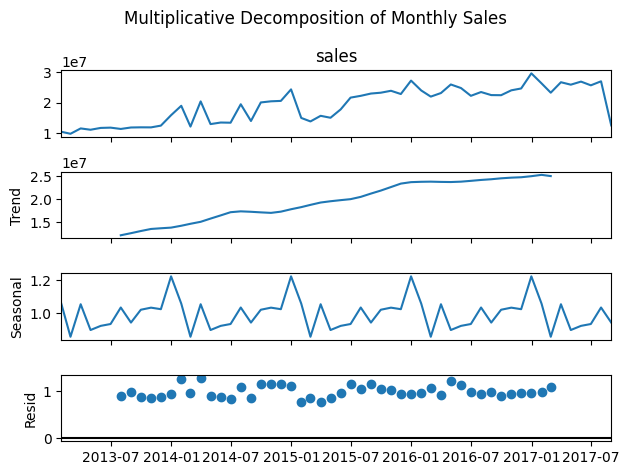

In [8]:
plt.figure(figsize=(15, 12))

result_add = seasonal_decompose(monthly_sales["sales"], model="multiplicative", period=12)
result_add.plot()
plt.suptitle("Multiplicative Decomposition of Monthly Sales")

plt.tight_layout()
plt.savefig("./figures/multiplicative_decomposition.png")
plt.show()

## __Data Splitting__

In [9]:
dates = monthly_sales.index
sales_values = monthly_sales["sales"].values

# Split temporal: 80% train, 20% test
split_index = int(len(monthly_sales) * 0.8)
train_dates = dates[:split_index]
test_dates = dates[split_index:]
train_sales = sales_values[:split_index]
test_sales = sales_values[split_index:]

print(f"Training Period: {train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} ({len(train_sales)} months)")
print(f"Testing Period: {test_dates[0].strftime('%Y-%m')} to {test_dates[-1].strftime('%Y-%m')} ({len(test_sales)} months)")

# Crear DataFrames separados para train y test
train_data = pd.DataFrame({'sales': train_sales}, index=train_dates)
test_data = pd.DataFrame({'sales': test_sales}, index=test_dates)

Training Period: 2013-01 to 2016-08 (44 months)
Testing Period: 2016-09 to 2017-08 (12 months)


## __Single Exponential Smoothing__

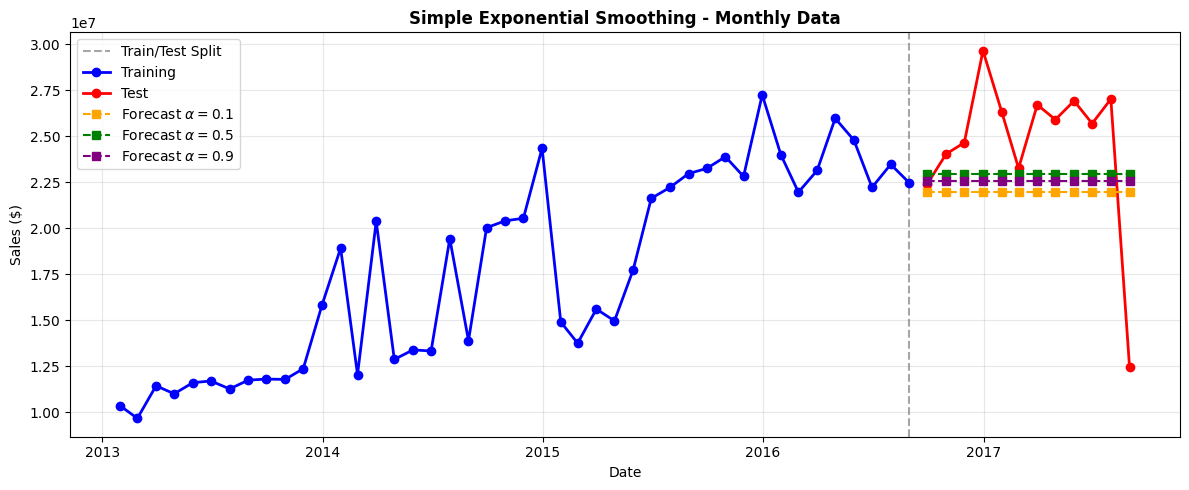

In [10]:
fit1 = SimpleExpSmoothing(train_data["sales"], initialization_method="estimated").fit(
    smoothing_level=0.1, optimized=False)
fcast1 = fit1.forecast(len(test_data))

fit2 = SimpleExpSmoothing(train_data["sales"], initialization_method="estimated").fit(
    smoothing_level=0.5, optimized=False)
fcast2 = fit2.forecast(len(test_data))

fit3 = SimpleExpSmoothing(train_data["sales"], initialization_method="estimated").fit(
    smoothing_level=0.9, optimized=False)
fcast3 = fit3.forecast(len(test_data))

# Visualización
plt.figure(figsize=(12, 5))

plt.axvline(x=train_dates[-1], color="gray", linestyle="--", alpha=0.7, label="Train/Test Split")
plt.plot(train_data.index, train_data["sales"], marker="o", color="blue", label="Training", linewidth=2)
plt.plot(test_data.index, test_data["sales"], marker="o", color="red", label="Test", linewidth=2)
# Forecast
plt.plot(fcast1.index, fcast1, marker="s", color="orange", linestyle='--', 
         label="Forecast $\\alpha=0.1$")
plt.plot(fcast2.index, fcast2, marker="s", color="green", linestyle="--", 
         label="Forecast $\\alpha=0.5$")
plt.plot(fcast3.index, fcast3, marker="s", color="purple", linestyle="--", 
         label="Forecast $\\alpha=0.9$")

plt.title("Simple Exponential Smoothing - Monthly Data", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/single_smoothing.png")
plt.show()

## __Double Exponential Smoothing__

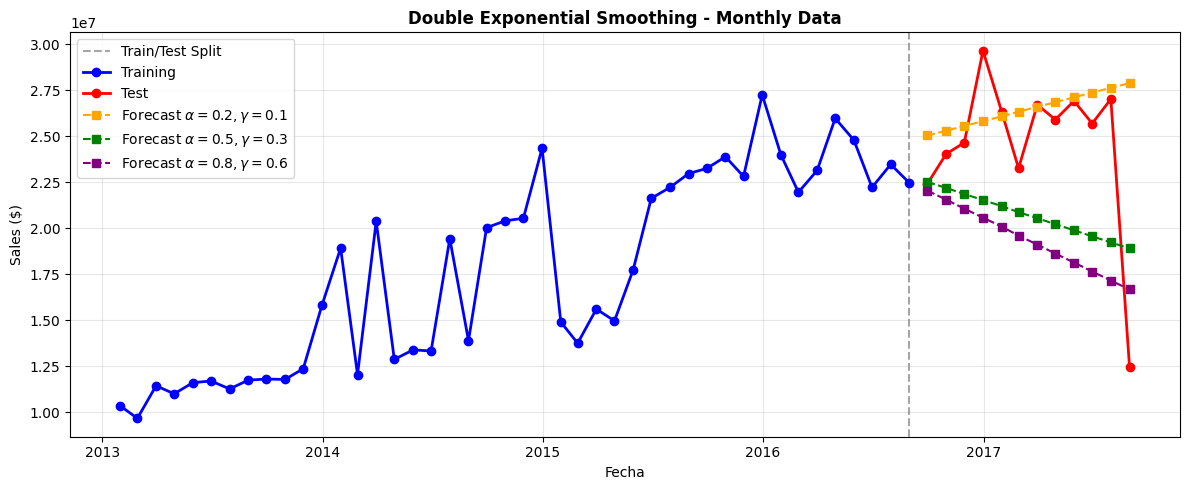

In [11]:
fit1_double = Holt(train_data['sales'], initialization_method="estimated").fit(
    smoothing_level=0.2, smoothing_trend=0.1, optimized=False)
fcast1_double = fit1_double.forecast(len(test_data))

fit2_double = Holt(train_data['sales'], initialization_method="estimated").fit(
    smoothing_level=0.5, smoothing_trend=0.3, optimized=False)
fcast2_double = fit2_double.forecast(len(test_data))

fit3_double = Holt(train_data['sales'], initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.6, optimized=False)
fcast3_double = fit3_double.forecast(len(test_data))

# Visualización
plt.figure(figsize=(12, 5))

plt.axvline(x=train_dates[-1], color="gray", linestyle="--", alpha=0.7, label="Train/Test Split")
plt.plot(train_data.index, train_data["sales"], marker="o", color="blue", label="Training", linewidth=2)
plt.plot(test_data.index, test_data["sales"], marker="o", color="red", label="Test", linewidth=2)
# Forecast
plt.plot(fcast1_double.index, fcast1_double, marker="s", color="orange", linestyle="--", label="Forecast $\\alpha=0.2, \\gamma=0.1$")
plt.plot(fcast2_double.index, fcast2_double, marker="s", color="green", linestyle="--", label='Forecast $\\alpha=0.5, \\gamma=0.3$')
plt.plot(fcast3_double.index, fcast3_double, marker="s", color="purple", linestyle="--", label='Forecast $\\alpha=0.8, \\gamma=0.6$')

plt.title("Double Exponential Smoothing - Monthly Data", fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/double_smoothing.png")
plt.show()

## __Triple Exponential Smoothing (Winters' Method)__

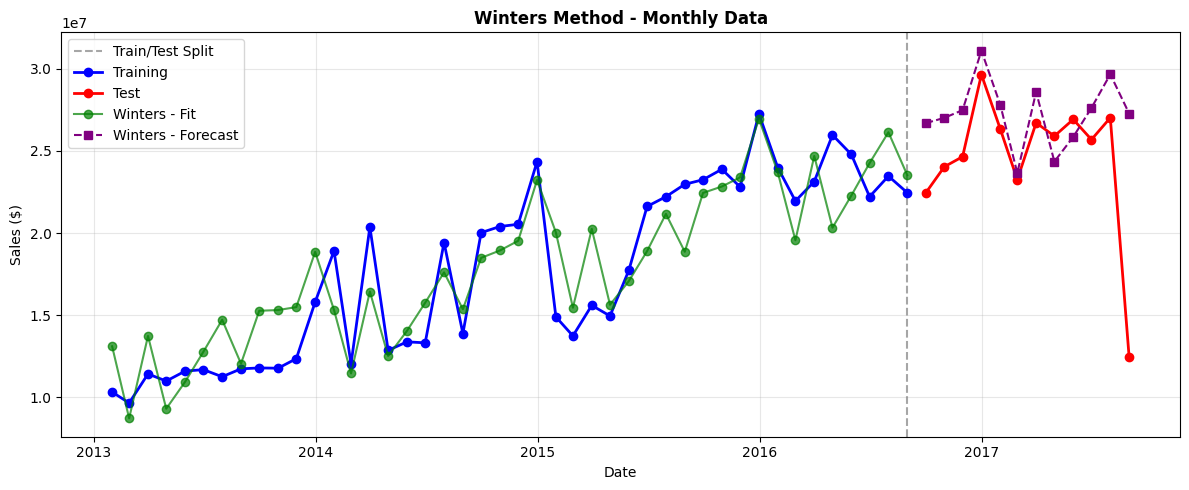

In [19]:
fit_winters = ExponentialSmoothing(
    train_data["sales"], 
    seasonal_periods=12, 
    trend="add", 
    seasonal="add", 
    initialization_method="estimated"
).fit()

fcast_winters = fit_winters.forecast(len(test_data))

# Visualización
plt.figure(figsize=(12, 5))

plt.axvline(x=train_dates[-1], color="gray", linestyle="--", alpha=0.7, label="Train/Test Split")
plt.plot(train_data.index, train_data["sales"], marker="o", color="blue", label="Training", linewidth=2)
plt.plot(test_data.index, test_data["sales"], marker="o", color="red", label="Test", linewidth=2)
# Fit and Forecast
plt.plot(fit_winters.fittedvalues.index, fit_winters.fittedvalues, marker="o", color="green", label="Winters - Fit", alpha=0.7)
plt.plot(fcast_winters.index, fcast_winters, marker="s", color="purple", linestyle="--", label="Winters - Forecast")

plt.title("Winters Method - Monthly Data", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/triple_smoothing.png")
plt.show()

## __Results__

In [20]:
test_actual = test_data['sales'].values

metrics_ses1 = calculate_metrics(test_actual, fcast1.values, "Single ES (α=0.1)")
metrics_ses2 = calculate_metrics(test_actual, fcast2.values, "Single ES (α=0.5)")
metrics_ses3 = calculate_metrics(test_actual, fcast3.values, "Single ES (α=0.9)")

metrics_des1 = calculate_metrics(test_actual, fcast1_double.values, "Double ES (α=0.2, γ=0.1)")
metrics_des2 = calculate_metrics(test_actual, fcast2_double.values, "Double ES (α=0.5, γ=0.3)")
metrics_des3 = calculate_metrics(test_actual, fcast3_double.values, "Double ES (α=0.8, γ=0.6)")

metrics_winters = calculate_metrics(test_actual, fcast_winters.values, "Winters Method")


Single ES (α=0.1):
  MAPE: 19.18%
  MAD: $4,192,336.90
  RMSE: $4,856,157.56

Single ES (α=0.5):
  MAPE: 16.73%
  MAD: $3,468,666.42
  RMSE: $4,411,133.08

Single ES (α=0.9):
  MAPE: 17.62%
  MAD: $3,741,481.07
  RMSE: $4,577,828.16

Double ES (α=0.2, γ=0.1):
  MAPE: 15.47%
  MAD: $2,579,565.74
  RMSE: $4,798,173.46

Double ES (α=0.5, γ=0.3):
  MAPE: 21.03%
  MAD: $4,969,272.11
  RMSE: $5,544,770.64

Double ES (α=0.8, γ=0.6):
  MAPE: 23.98%
  MAD: $5,936,765.89
  RMSE: $6,593,937.74

Winters Method:
  MAPE: 17.39%
  MAD: $3,108,348.35
  RMSE: $4,807,563.27


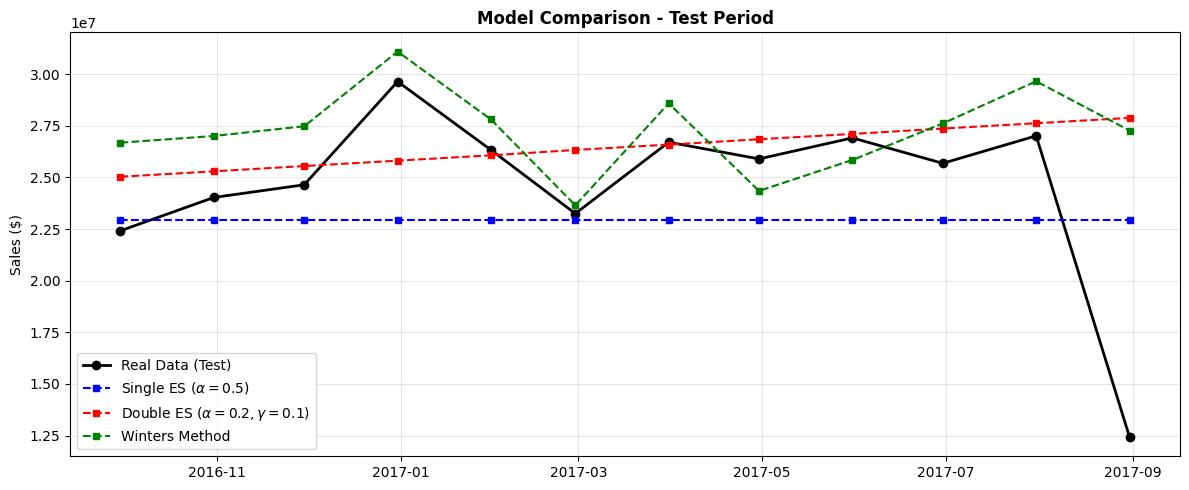

In [14]:
plt.figure(figsize=(12, 5))

plt.plot(test_data.index, test_data["sales"], marker="o", color="black", linewidth=2, label="Real Data (Test)", markersize=6)
plt.plot(fcast2.index, fcast2, marker="s", color="blue", linestyle="--", label="Single ES ($\\alpha=0.5$)", markersize=4)
plt.plot(fcast1_double.index, fcast1_double, marker="s", color="red", linestyle="--", label="Double ES ($\\alpha=0.2, \\gamma=0.1$)", markersize=4)
plt.plot(fcast_winters.index, fcast_winters, marker="s", color="green", linestyle="--", label="Winters Method", markersize=4)

plt.title("Model Comparison - Test Period", fontweight="bold")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/errors.png")
plt.show()